# Projeto 2 - NLP

-----

 Usaremos os algoritmos aprendidos e as técnicas vistas na segunda parte do curso para extrairmos informações relevantes de texto. Mais precisamente, de publicações no Twitter.

## Os Dados

Utilizaremos um Dataset obtido do Twitter com 100K postagens entre os dias 01/08/2018 e 20/10/2018. Cada postagem é classificada como **positiva**, **negativa** ou **neutra**.  

Descrição das colunas:

- **id**: ID único para o tweet  
- **tweet_text**: Texto da publicação no Twitter  
- **tweet_date**: Data da publicação no Twitter  
- **sentiment**: 0, se negativo; 1, se positivo; 2, se neutro  
- **query_used**: Filtro utilizado para buscar a publicação

## O Problema

Você deverá desenvolver um modelo para detectar o sentimento de uma publicação do Twitter a classificando em uma das três categorias: **positiva**, **negativa** ou **neutra**. O texto da publicação está disponível na coluna "tweet_text". Teste pelo menos 2 técnicas de NLP diferentes e escolha a métrica de avaliação que julgar mais pertinente.  

Para ajudar no desenvolvimento, é possível dividir o projeto em algumas fases:

- **Análise de consistência dos dados**: analise se os dados estão fazendo sentido, se os campos estão completos e se há dados duplicados ou faltantes. Se julgar necessário, trate-os.    


- **Análise exploratória**: analise a sua base como um todo, verifique o balanceamento entre as classes e foque, principalmente, na coluna ```tweet_text```.    


- **Pré-processamento e transformações**: projetos de NLP exigem um considerável pré-processamento. Foque no tratamento da string do texto. Procure começar com tratamentos simples e adicione complexidade gradualmente. Nessa etapa você testará diferentes técnicas de transformações, como o Bag Of Words e o TF-IDF.    


- **Treinamento do modelo**: depois das transformações, você poderá executar o treinamento do modelo classificador. Nessa etapa o problema se torna semelhante aos abordados na primeira parte do módulo. Você pode testar diversos classificadores como RandomForest, AdaBoost, entre outros. Otimize os hiperparâmetros do modelo com técnicas como a GridSearch e a RandomizedSearch.    


- **Conclusões**: descreva, em texto, as conclusões sobre os seus estudos. O modelo é capaz de identificar o sentimento das publicações? É possível extrapolar o modelo para outros contextos, como a análise de sentimento de uma frase qualquer? Pense em questões pertinentes e relevantes que você tenha obtido durante o desenvolvimento do projeto!     



## Dicas
     

### Tente encontrar possíveis vieses

É muito comum que modelos de NLP possuam fortes vieses, como a tendência de relacionar palavras específicas com alguma classe de saída. Tente encontrar vieses no seu estudo, isso pode ajudar a tirar boas conclusões. o campo "query_used" pode ser útil para essa análise.  

### O pré-processamento é a chave para um bom desempenho

Essa é a etapa que mais vai contribuir para o desempenho do seu modelo. Seja criativo e desenvolva essa etapa de uma maneira que seja fácil de aplicar o mesmo processamento para uma nova base, você terá que fazer isso para gerar a base de submissão.

-------

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics import classification_report
from nltk import pos_tag
import emoji
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from nltk.stem import RSLPStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from tensorflow import keras
import glob
import tensorflow
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
from skimage import feature

In [46]:
#load the cvs and transform into dataset
tweets = pd.read_csv('./Dados/train/Train3Classes.csv', sep = ',')
#dataset visualization
tweets

,id,tweet_text,tweet_date,sentiment,query_used
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:)
...,...,...,...,...,...
94995,1041831666883321856,Cuba e defensor de direitos humanos se unem co...,Mon Sep 17 23:30:00 +0000 2018,2,jornaloglobo
94996,1032352892194369536,#Oportunidade ➡️ Venha fazer parte da nossa eq...,Wed Aug 22 19:44:44 +0000 2018,2,#oportunidade
94997,1046785538542440448,@96syoo EU SEI 😭😭 é por isso que significa mui...,Mon Oct 01 15:34:55 +0000 2018,0,:(
94998,1045457469110177792,@louistsexhes N te conheço mas posta :D,Thu Sep 27 23:37:38 +0000 2018,1,:)


### Data consistence evaluation

In [3]:
#Geting info about the types and absents data
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95000 non-null  int64 
 1   tweet_text  95000 non-null  object
 2   tweet_date  95000 non-null  object
 3   sentiment   95000 non-null  int64 
 4   query_used  95000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


In [4]:
#Verifying if there'is duplicated data
tweets.duplicated().value_counts()

False    95000
dtype: int64

### EDA

In [47]:
tweet = tweets.sample(frac=0.05, replace=False)

In [43]:
tweet.shape

(9500, 5)

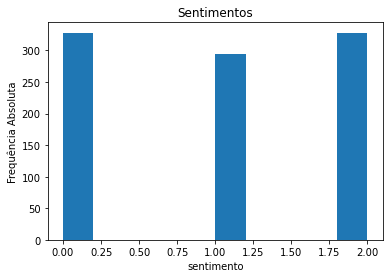

In [7]:
#Grafic view about setiment column
plt.title('Sentimentos')
plt.xlabel('sentimento')
plt.ylabel('Frequência Absoluta')
plt.hist(tweet['sentiment'], 10)
plt.show()

In [8]:
# Verifying the balance of dataset
tweets['sentiment'].value_counts()

0    31696
1    31678
2    31626
Name: sentiment, dtype: int64

### Pre processing and transformations

In [48]:
def limpezaTexto(string):
    import spacy
    nlp = spacy.load("pt_core_news_sm")
    from nltk.corpus import stopwords
    words_pt = nltk.corpus.stopwords.words('portuguese')
    import emoji
    happy =  re.sub(r'[:.][)]', 'feliz', string) #char replace: from  :) to feliz
    happy_D =  re.sub(r'[:.][D]', 'feliz', happy)#char replace: from  :D to feliz
    sad = re.sub(r'[:.][(]', 'triste', happy_D) #char replace: from  :() to triste
    html = re.sub(r'ht.*/.*', ' ', sad)#removal of hyperlinks
    unicode = unidecode(html)#removal of Grafic accentuations
    emoji = emoji.demojize(unicode)#emojis transform to code
    no_emoji = re.sub(r'[:][\w]*[:]', " ", emoji)#removal of generic emojis
    no_arroba = re.sub(r'[\Wa-zA-Z0-9]*[\W][@][\w.]+|[@.][\w.]+', ' ', no_emoji)#quote removal
    especial = re.sub(r'[^a-zA-Z0-9]+', ' ', no_arroba)#specials chars removal
    no_number = re.sub(r'[\d]', ' ', especial)#digits removal
    doc = nlp(no_number)#lemmatization instance  
    tokens = [token.lemma_.lower() for token in doc] #lemmatization. The consequence is the string tokenization too
    for palavra in tokens: #loop to stopwords removals from dataset
        if palavra in tokens:
            i = tokens.index(palavra)
            tokens.pop(i)
    return tokens

In [49]:
#applying the datacleaning function. The data exit is a list with tokenized words in each row of dataset
tweet['tweet_text_clean'] = tweet['tweet_text'].apply(lambda x: limpezaTexto(x))


In [50]:
tweet['tweet_text_clean']

49959    [com, tag, mande, recado, um, de, delinquente,...
21566                               [clima, muito, triste]
28463                                                 [na]
7366                     [ja, todo, querer, de, em o, cel]
72624                                     [vc, eu, triste]
                               ...                        
32044                [vaga, ajudante, producao, e, de, em]
44121                                    [seu, amiga, ter]
52111    [ahhh, demais, tempo, passar, manau, quiser, m...
64382                         [xr, novo, baratinho, apple]
10462           [reafirmar, eleitor, usar, de, em o, de o]
Name: tweet_text_clean, Length: 4750, dtype: object

Turning the list of word of each row in a unique string by applying the join function


In [53]:
tweet['tweet_text_join'] = tweet['tweet_text_clean'].apply(lambda x: ' '.join(x))

In [54]:
#Cleaned dataset view
tweet['tweet_text_join']

49959    com tag mande recado um de delinquente usar tr...
21566                                   clima muito triste
28463                                                   na
7366                            ja todo querer de em o cel
72624                                         vc eu triste
                               ...                        
32044                       vaga ajudante producao e de em
44121                                        seu amiga ter
52111    ahhh demais tempo passar manau quiser marcar n...
64382                              xr novo baratinho apple
10462                  reafirmar eleitor usar de em o de o
Name: tweet_text_join, Length: 4750, dtype: object

In [55]:
tweet

,id,tweet_text,tweet_date,sentiment,query_used,tweet_text_clean,tweet_text_join
49959,1031557679808962560,Vamos com a #Tag #JackDorsey !!! Mande o recad...,Mon Aug 20 15:04:50 +0000 2018,2,#trabalho,"[com, tag, mande, recado, um, de, delinquente,...",com tag mande recado um de delinquente usar tr...
21566,1049286945900249090,O clima tá muito pesado. :(,Mon Oct 08 13:14:37 +0000 2018,0,:(,"[clima, muito, triste]",clima muito triste
28463,1047471835284008960,SOBRA NA :),Wed Oct 03 13:02:01 +0000 2018,1,:),[na],na
7366,1050729399073542144,@mylifeasmermaid ja curti todas haha queria po...,Fri Oct 12 12:46:25 +0000 2018,1,:),"[ja, todo, querer, de, em o, cel]",ja todo querer de em o cel
72624,1046239958451855362,@dihzaoricardo Vc soh me ilude :(,Sun Sep 30 03:26:58 +0000 2018,0,:(,"[vc, eu, triste]",vc eu triste
...,...,...,...,...,...,...,...
32044,1039592115083374592,#Vaga para Ajudante de Produção detalhes e env...,Tue Sep 11 19:10:49 +0000 2018,2,#oportunidade,"[vaga, ajudante, producao, e, de, em]",vaga ajudante producao e de em
44121,1049303038417129473,Qual sua melhor amiga? — Não tenho :( https://...,Mon Oct 08 14:18:34 +0000 2018,0,:(,"[seu, amiga, ter]",seu amiga ter
52111,1050718435531993088,"@chellbuzogany ahhh, que demais! quanto tempo ...",Fri Oct 12 12:02:51 +0000 2018,1,:),"[ahhh, demais, tempo, passar, manau, quiser, m...",ahhh demais tempo passar manau quiser marcar n...
64382,1039950582340100096,iPhone XR: o novo iPhone “baratinho” da Apple ...,Wed Sep 12 18:55:14 +0000 2018,2,exame,"[xr, novo, baratinho, apple]",xr novo baratinho apple


## Machine Learning

To lead with words in Machine Learn, we need to translate to the algorithm the words into numbers, this transformation we call bag of words - BOW. In this project it will be used Count Vectorizer, TF-IDF and Word Embeddings

In [56]:
# Slicing the dataset in feature and target. Used the columns tweet_text_join to apply the method TF-IDF Vectorizer and 
#CountVectorizer

X = tweet['tweet_text_join']
y = tweet['sentiment']



# slicing the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                     y,
                                                     test_size = 0.3,
                                                     random_state = 42)

Count Vectorizer

In [57]:
# insance
cv = CountVectorizer()

# Transforma os dados nas matrizes de saída
X_train_cv = cv.fit_transform(X_train).toarray()
X_test_cv = cv.transform(X_test).toarray()


TF-IDF

In [58]:
#applying the TfIdf vectorizer
tfidf = TfidfVectorizer(use_idf = True)

X_train_tfidf = tfidf.fit_transform(X_train).todense()
X_test_tfidf  = tfidf.transform(X_test).todense()

Word Embeddings

In [59]:
# Slicing the dataset in feature and target. Used the columns tweet_text_clean to apply the method word embeddings. 
# To do this transformation it will need da tokenized data, thats why we will use the tweet_text_clean column

X_we = tweet['tweet_text_clean']
y_we = tweet['sentiment']


# slicing the dataset in train and test
X_train_we, X_test_we, y_train_we, y_test_we = train_test_split(X_we,
                                                     y_we,
                                                     test_size = 0.3,
                                                     random_state = 42)

In [64]:
X_we = tweet['tweet_text_clean']
y_we = tweet['sentiment']


# slicing the dataset in train and test
X_train_we, X_test_we, y_train_we, y_test_we = train_test_split(X_we,
                                                     y_we,
                                                     test_size = 0.3,
                                                     random_state = 42)

from gensim.models import Word2Vec
#applying the word embeddings
modelWord2Vec = Word2Vec(X_train_we, min_count = 2)

words = set(modelWord2Vec.wv.index_to_key )

X_train_vect = np.array([np.array([modelWord2Vec.wv[i] for i in ls if i in words])
                         for ls in X_train_we])
X_test_vect = np.array([np.array([modelWord2Vec.wv[i] for i in ls if i in words])
                         for ls in X_test_we])

C:\Users\mari.fernandes\AppData\Local\Temp\ipykernel_18960\2954864449.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([modelWord2Vec.wv[i] for i in ls if i in words])
C:\Users\mari.fernandes\AppData\Local\Temp\ipykernel_18960\2954864449.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([modelWord2Vec.wv[i] for i in ls if i in words])


### Trainning and evaluating the models

Using the Count Vectorizer to fit the models

In [97]:
def fit_model(X_train, y_train, X_test, y_test):
    modelMultinomial = MultinomialNB()
    modelGaussian = GaussianNB()
    modelRandomforest = RandomForestClassifier()
    modelSVC = LinearSVC()

    model_list = [modelMultinomial, modelGaussian, modelRandomforest, modelSVC]
    resultado_experimentos = {"estimador" : [],
                              "f1_treino" : [],
                              "f1_teste" : []
                             }
    for model in model_list:
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        #calculating the gap (diference) between f1_train and f1_test 
        dict_metricas_treino = classification_report(y_train, y_train_pred, output_dict=True)
        dict_metricas_test = classification_report(y_test, y_pred, output_dict=True)
        f1_treino = dict_metricas_treino["weighted avg"]["f1-score"]
        f1_teste = dict_metricas_test["weighted avg"]["f1-score"]
        resultado_experimentos["estimador"].append(str(model))
        resultado_experimentos["f1_treino"].append(f1_treino)
        resultado_experimentos["f1_teste"].append(f1_teste)
        
        print('REPORT')
        print(f'Model: {model}')
        print('TRAIN')
        print(classification_report(y_train, y_train_pred))
        print('-'*80)
        print('TEST')
        print(classification_report(y_test, y_pred))
        print("#"*80)
    
    df_results = pd.DataFrame(resultado_experimentos)
    df_results["gap"] = (df_results["f1_treino"] - df_results["f1_teste"]).apply(lambda x: x if x > 0 else np.inf)
    df_results = df_results.sort_values("f1_teste", ascending=False).sort_values("gap")
    return df_results

    


Using Count Vectorizer data

In [98]:
fit_model(X_train_cv, y_train, X_test_cv, y_test)

REPORT
Model: MultinomialNB()
TRAIN
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1115
           1       0.90      0.90      0.90      1087
           2       0.94      0.94      0.94      1123

    accuracy                           0.92      3325
   macro avg       0.92      0.92      0.92      3325
weighted avg       0.92      0.92      0.92      3325

--------------------------------------------------------------------------------
TEST
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       483
           1       0.72      0.71      0.72       464
           2       0.83      0.82      0.82       478

    accuracy                           0.77      1425
   macro avg       0.77      0.77      0.77      1425
weighted avg       0.77      0.77      0.77      1425

################################################################################
REPORT
Model: GaussianNB()
TRAIN
  

,estimador,f1_treino,f1_teste,gap
0,MultinomialNB(),0.919390,0.774037,0.145353
3,LinearSVC(),0.980181,0.765462,0.214718
2,RandomForestClassifier(),0.992186,0.724147,0.268040
1,GaussianNB(),0.848679,0.499235,0.349444


Using TF-IDF data

In [99]:
fit_model(X_train_tfidf,y_train, X_test_tfidf, y_test)

REPORT
Model: MultinomialNB()
TRAIN


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1115
           1       0.92      0.90      0.91      1087
           2       0.96      0.94      0.95      1123

    accuracy                           0.93      3325
   macro avg       0.93      0.93      0.93      3325
weighted avg       0.93      0.93      0.93      3325

--------------------------------------------------------------------------------
TEST
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       483
           1       0.72      0.69      0.71       464
           2       0.85      0.80      0.82       478

    accuracy                           0.77      1425
   macro avg       0.77      0.77      0.77      1425
weighted avg       0.77      0.77      0.77      1425

################################################################################


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


REPORT
Model: GaussianNB()
TRAIN
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1115
           1       0.95      0.67      0.79      1087
           2       1.00      0.88      0.94      1123

    accuracy                           0.85      3325
   macro avg       0.89      0.85      0.85      3325
weighted avg       0.89      0.85      0.85      3325

--------------------------------------------------------------------------------
TEST
              precision    recall  f1-score   support

           0       0.46      0.78      0.58       483
           1       0.39      0.23      0.29       464
           2       0.76      0.53      0.62       478

    accuracy                           0.52      1425
   macro avg       0.54      0.52      0.50      1425
weighted avg       0.54      0.52      0.50      1425

################################################################################


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


REPORT
Model: RandomForestClassifier()
TRAIN
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1115
           1       1.00      0.99      0.99      1087
           2       0.98      1.00      0.99      1123

    accuracy                           0.99      3325
   macro avg       0.99      0.99      0.99      3325
weighted avg       0.99      0.99      0.99      3325

--------------------------------------------------------------------------------
TEST
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       483
           1       0.73      0.64      0.68       464
           2       0.75      0.87      0.81       478

    accuracy                           0.75      1425
   macro avg       0.75      0.75      0.74      1425
weighted avg       0.75      0.75      0.74      1425

################################################################################


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


REPORT
Model: LinearSVC()
TRAIN
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1115
           1       0.98      0.96      0.97      1087
           2       0.98      1.00      0.99      1123

    accuracy                           0.98      3325
   macro avg       0.98      0.98      0.98      3325
weighted avg       0.98      0.98      0.98      3325

--------------------------------------------------------------------------------
TEST
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       483
           1       0.76      0.67      0.71       464
           2       0.78      0.88      0.83       478

    accuracy                           0.77      1425
   macro avg       0.77      0.77      0.77      1425
weighted avg       0.77      0.77      0.77      1425

################################################################################


,estimador,f1_treino,f1_teste,gap
0,MultinomialNB(),0.929366,0.768432,0.160935
3,LinearSVC(),0.977089,0.769592,0.207497
2,RandomForestClassifier(),0.992187,0.744993,0.247194
1,GaussianNB(),0.851940,0.501731,0.350209


Using Word Embeddings data

In [100]:
fit_model(X_train_vect, X_test, X_test_vect, y_test)

ValueError: setting an array element with a sequence.

### Tunning the models with Hyperparameters to Random Forest

GridSearch with TF-IDF data

In [103]:
def grid_instance(X_train, y_train):
    parametrosRandomForest = {'n_estimators': [10, 20, 50, 100],
                              'criterion': ['gini', 'entropy'],
                              'max_depth' : [15, 25, 40],
                              'min_samples_split': [2, 5, 10],
                              'min_samples_leaf' : [1, 5, 10],
                              'max_features': ['sqrt', 'log2']
                         }

    modelRandomforest = RandomForestClassifier()
    gridSearch = GridSearchCV(estimator = modelRandomforest, param_grid = parametrosRandomForest)
    gridSearch.fit(X_train, y_train)
    best_params = gridSearch.best_params_
    best_result = gridSearch.best_score_
    print(f'Melhores parâmetros do modelo Random Forest:')
    for key, value in best_params.items():
        print(f'{key}: {value}')
    print('Score: ',best_result)

In [104]:
grid_instance(X_train_cv, y_train)

NameError: name 'model' is not defined

In [ ]:
grid_instance(X_train_tfidf, y_train)

In [ ]:
grid_instance(X_train_vec, y_train)

##### Tunning the models with the best parameters

In [ ]:
# models instances

def tunning(X_train, y_train, X_test, y_test, name_of_bow)

    modelRandomforest = RandomForestClassifier(criterion = 'gini', 
                                           max_depth = 40, 
                                           max_features = 'log2', 
                                           min_samples_split =  5)
    modelSVC = LinearSVC()

    # fitting the models
    modelRandomforest.fit(X_train, y_train)
    modelSVC.fit(X_train, y_train)
# Teste Predictions generates
    y_pred_random = modelRandomforest.predict(X_test)
    y_train_pred_random = model.predict(X_train)
    y_pred_SVC = modelRandomforest.predict(X_test)
    y_train_pred_SVC = model.predict(X_train)
       
    print(f'REPORT with {name_of_the_bow}')
    print(f'Model: Random Forest')
    print('TRAIN')
    print(classification_report(y_train, y_train_pred_random))
    print('-'*80)
    print('TEST')
    print(classification_report(y_test, y_pred_random))
    print("#"*80)
    print(f'Model: SVC')
    print('TRAIN')
    print(classification_report(y_train, y_train_pred_SVC))
    print('-'*80)
    print('TEST')
    print(classification_report(y_test, y_pred_SVC))
    print("#"*80)
    #calculating the gap (diference) between f1_train and f1_test 
    dict_metricas_treino_random = classification_report(y_train, y_train_pred_random, output_dict = True)
    dict_metricas_test_random = classification_report(y_test, y_pred_random, output_dict = True)
    
    dict_metricas_treino_SVC = classification_report(y_train, y_train_pred_SVC, output_dict = True)
    dict_metricas_test_SVC = classification_report(y_test, y_pred_SVC, output_dict = True)
    
    f1_treino_random = dict_metricas_treino_random["weighted avg"]["f1-score"]
    f1_teste_random = dict_metricas_test_random["weighted avg"]["f1-score"]
    
    f1_treino_SVC = dict_metricas_treino_SVC["weighted avg"]["f1-score"]
    f1_teste_SVC = dict_metricas_test_SVC["weighted avg"]["f1-score"]
    
    resultado_experimentos["estimador"].append('Random Forest'))
    resultado_experimentos["estimador"].append('SVC'))
    resultado_experimentos["f1_treino"].append(f1_treino_random)
    resultado_experimentos["f1_teste"].append(f1_teste_random)
    resultado_experimentos["f1_treino"].append(f1_treino_SVC)
    resultado_experimentos["f1_teste"].append(f1_teste_SVC)
    df_results = pd.DataFrame(resultado_experimentos)
    
    df_results["gap"] = (df_results["f1_treino"] - df_results["f1_teste"]).apply(lambda x: x if x > 0 else np.inf)
    df_results = df_results.sort_values("f1_teste", ascending=False).sort_values("gap")
    return df_result


In [ ]:
tunning(X_train_cv, y_train)

In [ ]:
tunning(X_train_tfidf, y_train)

In [ ]:
tunning(X_train_vec, y_train)

### Neural Network

Using Count vectorizer

In [166]:
X = tweet['tweet_text_join']
y = tweet['sentiment']
X_train, X_val, y_train, y_val = train_test_split(X,
                                                     y,
                                                     test_size = 0.3,
                                                     random_state = 42)

In [167]:
cv = CountVectorizer()

X_train_cv = cv.fit_transform(X_train).toarray()
X_val_cv = cv.transform(X_val).toarray()

In [168]:
df_cv = pd.DataFrame(X_train_cv, columns=cv.get_feature_names())
df_cv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,2e,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaah,aaaaaaah,aaaaaar,...,york,youtube,zap,zelandia,zema,zequinha,zerar,zero,ziraldo,zona
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
model = Sequential()
model.add(Dense(50, activation = "relu", input_shape=(4744,)))
model.add(Dense(50))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(
              optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"]
             )

results = model.fit(
                     X_train_cv, y_train,
                     epochs= 3,
                     batch_size = 500,
                     validation_data = (X_val_cv, y_val)
                    )

Epoch 1/3
7/7 [==============================] - 2s 92ms/step - loss: 1.0894 - accuracy: 0.4271 - val_loss: 1.0669 - val_accuracy: 0.6161
Epoch 2/3
7/7 [==============================] - 0s 31ms/step - loss: 1.0284 - accuracy: 0.7579 - val_loss: 1.0183 - val_accuracy: 0.7130
Epoch 3/3
7/7 [==============================] - 0s 30ms/step - loss: 0.9463 - accuracy: 0.8418 - val_loss: 0.9453 - val_accuracy: 0.7368


In [170]:
print(np.mean(results.history["val_accuracy"]))

0.6886549790700277


In [171]:
df = pd.DataFrame(results.history)
df

,loss,accuracy,val_loss,val_accuracy
0,1.089414,0.427068,1.066922,0.616140
1,1.028412,0.757895,1.018335,0.712982
2,0.946328,0.841805,0.945319,0.736842


TF-IDF Vectorizer

In [172]:
X = tweet['tweet_text_join']
y = tweet['sentiment']
X_train, X_val, y_train, y_val = train_test_split(X,
                                                     y,
                                                     test_size = 0.3,
                                                     random_state = 42)

In [173]:
tfidf = TfidfVectorizer(use_idf = True)

X_train_tfidf = tfidf.fit_transform(X_train).todense()
X_val_tfidf  = tfidf.transform(X_val).todense()

In [174]:
df_tfidf = pd.DataFrame(X_train_tfidf, columns=cv.get_feature_names())

model = Sequential()
model.add(Dense(50, activation = "relu", input_shape=(df_cv.shape[1],)))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(
              optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"]
             )

results = model.fit(
                     X_train_tfidf, y_train,
                     epochs= 4,
                     batch_size = 500,
                     validation_data = (X_val_tfidf, y_val)
                    )



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/4
7/7 [==============================] - 2s 96ms/step - loss: 1.0918 - accuracy: 0.4355 - val_loss: 1.0768 - val_accuracy: 0.5642
Epoch 2/4
7/7 [==============================] - 0s 26ms/step - loss: 1.0499 - accuracy: 0.6869 - val_loss: 1.0245 - val_accuracy: 0.6695
Epoch 3/4
7/7 [==============================] - 0s 27ms/step - loss: 0.9496 - accuracy: 0.8256 - val_loss: 0.9108 - val_accuracy: 0.7137
Epoch 4/4
7/7 [==============================] - 0s 26ms/step - loss: 0.7548 - accuracy: 0.8827 - val_loss: 0.7481 - val_accuracy: 0.7277


In [175]:
print(np.mean(results.history["val_accuracy"]))

0.6687719374895096


In [176]:
df = pd.DataFrame(results.history)
df

,loss,accuracy,val_loss,val_accuracy
0,1.091807,0.435489,1.076808,0.564211
1,1.049915,0.686917,1.024460,0.669474
2,0.949587,0.825564,0.910814,0.713684
3,0.754828,0.882707,0.748094,0.727719


Word Embedings

In [177]:
max_features = 20000
maxlen = 80  
batch_size = 32

In [178]:
X_we = tweet['tweet_text_clean']
y_we = tweet['sentiment']



X_train, X_val, y_train, y_val = train_test_split(X_we,
                                                  y_we,
                                                  test_size = 0.3,
                                                  random_state = 42)

vocab_size = 10000
embedding_dim = 16
max_length = 120

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

padded = pad_sequences(sequences,maxlen=max_length)

val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(val_sequences,maxlen=max_length)

In [182]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(50, activation = "relu"))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(
              optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"]
             )

results = model.fit(
                     padded, y_train,
                     epochs= 5,
                     batch_size = 64,
                     validation_data = (val_padded, y_val)
                    )



Epoch 1/5
52/52 [==============================] - 2s 14ms/step - loss: 1.0808 - accuracy: 0.4611 - val_loss: 1.0243 - val_accuracy: 0.5937
Epoch 2/5
52/52 [==============================] - 0s 8ms/step - loss: 0.7467 - accuracy: 0.7128 - val_loss: 0.6260 - val_accuracy: 0.7081
Epoch 3/5
52/52 [==============================] - 0s 8ms/step - loss: 0.3442 - accuracy: 0.8710 - val_loss: 0.5309 - val_accuracy: 0.7586
Epoch 4/5
52/52 [==============================] - 0s 8ms/step - loss: 0.1708 - accuracy: 0.9462 - val_loss: 0.5861 - val_accuracy: 0.7495
Epoch 5/5
52/52 [==============================] - 0s 8ms/step - loss: 0.0949 - accuracy: 0.9666 - val_loss: 0.6362 - val_accuracy: 0.7586


In [180]:
print(np.mean(results.history["val_accuracy"]))

0.7149473667144776


In [181]:
df = pd.DataFrame(results.history)
df

,loss,accuracy,val_loss,val_accuracy
0,1.081902,0.414436,1.014091,0.615439
1,0.776532,0.666466,0.677765,0.698947
2,0.420119,0.823459,0.575606,0.741754
3,0.240391,0.915188,0.603740,0.760000
4,0.134166,0.955789,0.646227,0.758596


### Implications

Descreva, em texto, as conclusões sobre os seus estudos. O modelo é capaz de identificar o sentimento das publicações? É possível extrapolar o modelo para outros contextos, como a análise de sentimento de uma frase qualquer? Pense em questões pertinentes e relevantes que você tenha obtido durante o desenvolvimento do projeto!